# Router

## Review
En los archivos anteriores se crearin graficos que usaban mensajes como estado y
modelos de chat con herramientas
Por tanto los graficos pueden:
* Retornar una llamada de Tool
* Retornar una respuesta de lenguaje natural

## En este archivo:

Podemos ver esto [Router] como un enrutador que el modelo de chat utiliza para enrutar directamente entre una respuesta o la llamada a una herramienta [Tool] según la entrada del usuario

Este es un ejemplo simple de un [AGENTE], donde el llm dirige el flujo de control, ya sea llamando a una herramienta o solo respondiendo

![routers.png](DHAgent\LangGraphAgent\app\imagenes\routers.png)



¡Extendamos nuestro gráfico para que funcione con cualquiera de las salidas!

Para esto, podemos usar dos ideas:
* Agregar un nodo que llamará a nuestra herramienta.
* Agregar una arista condicional que analizará la salida del modelo de chat y se dirigirá a nuestro nodo de llamada de herramienta o simplemente finalizará si no se realiza ninguna llamada de herramienta.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from general_conf.imports import *
load_dotenv(find_dotenv())
print("API KEY INGRESADA CON ÉXITO")

API KEY INGRESADA CON ÉXITO


In [3]:
from langchain_openai import ChatOpenAI

def multiply(a:int, b:int) -> int:
    """
    Multiplica a por b
    
    Args:
        a: primer int
        b: segundo int 
    """
    return a * b

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([multiply])

Utilizamos el *componente prefabricado* [ToolNode] y simplemente le pasamos una lista de nuestras herramientas [tools] para inicializarlo

Tambien utilizamos el *compomponente prefabricado* [tools_condition] como nuestro edge condicional

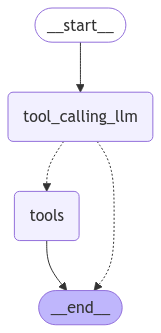

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

#Nodo

def tool_calling_llm(state: MessagesState):
    return {"messages":[llm_with_tools.invoke((state["messages"]))]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [5]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="Puedes decirme cuantos planetas hay en el sistema solar")]
messages = graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()



NotFoundError: Error code: 404 - {'error': {'message': 'The model `gpt-4o` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}